# Finetuning SKU110K

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

## Loading the data
- specifying the transforms for train en val sets 
- creating dataset objects
- creating dataloader objects
- extracting the class names
- setting up the device being used for training [cpu/cuda:0]

In [3]:
# Dictionary with data augmentation and normalization for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  #resnet50 typically takes a 224x244 image as input
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),  #resnet50 typically takes a 224x244 image as input
        transforms.ToTensor(),
    ]),
}

data_dir = 'data/sku110k_ft'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(f"Dataset sizes: {dataset_sizes}",end="\n\n")

class_names = image_datasets['train'].classes
print(f"class_names: {class_names}", end="\n\n")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Dataset sizes: {'train': 46, 'val': 45}

class_names: ['coca_cola', 'colgate']

Using device cuda:0


## Visualize a couple examples from sku110k_ft

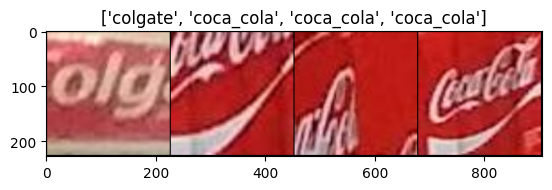

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## training

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the predictions

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

In [7]:
#downloaded models are sace to users/ovanl/.cache/torch/hub/checkpoints/resnet50.path
model_ft = models.resnet50()

#freezing the weights of the convolutional layers by turning of grad, which means the gradient won't be 
#calculated/tracked anymore with autograd
for param in model_ft.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
print(f"last layer before adjustment {model_ft.fc} ")

#replacing the final fully connected layer from a 2048,1000 -> 2048,len(class_names)
model_ft.fc = nn.Linear(num_ftrs, len(class_names)) #new linear layer has autograd on automatically
print(f"last layer after adjustment {model_ft.fc} ")

#loading the neural network with pretrained weights:
model_ft.load_state_dict( torch.load("resnet50_ft.pth"))
print("Resnet50 weights loaded from file ")
#saving the current network parameters to a file
#torch.save(model_ft.state_dict(), "resnet50_ft.pth")

#move model to GPU for training on CUDA device
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

last layer before adjustment Linear(in_features=2048, out_features=1000, bias=True) 
last layer after adjustment Linear(in_features=2048, out_features=2, bias=True) 
Resnet50 weights loaded from file 


## Train and evaluate

In [8]:
#only fine tuning lineair classifier layer
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
#saving the current network parameters to a file
torch.save(model_ft.state_dict(), "resnet50_ft_after.pth")

Epoch 0/24
----------
train Loss: 0.6508 Acc: 0.6304
val Loss: 1.2915 Acc: 0.5333

Epoch 1/24
----------
train Loss: 0.5550 Acc: 0.7174
val Loss: 0.7710 Acc: 0.2667

Epoch 2/24
----------
train Loss: 0.4416 Acc: 0.8261
val Loss: 0.7008 Acc: 0.5111

Epoch 3/24
----------
train Loss: 0.4040 Acc: 0.8261
val Loss: 1.3615 Acc: 0.5333

Epoch 4/24
----------
train Loss: 0.3052 Acc: 0.8913
val Loss: 0.6329 Acc: 0.5333

Epoch 5/24
----------
train Loss: 0.5166 Acc: 0.7391
val Loss: 0.6372 Acc: 0.7111

Epoch 6/24
----------
train Loss: 0.5544 Acc: 0.7391
val Loss: 2.0247 Acc: 0.5333

Epoch 7/24
----------
train Loss: 0.4808 Acc: 0.8478
val Loss: 1.3537 Acc: 0.5333

Epoch 8/24
----------
train Loss: 0.1228 Acc: 0.9783
val Loss: 1.2918 Acc: 0.5333

Epoch 9/24
----------
train Loss: 0.3094 Acc: 0.8478
val Loss: 1.2832 Acc: 0.5333

Epoch 10/24
----------
train Loss: 0.3166 Acc: 0.7826
val Loss: 0.9739 Acc: 0.5333

Epoch 11/24
----------
train Loss: 0.2673 Acc: 0.8696
val Loss: 0.9378 Acc: 0.5333

Ep

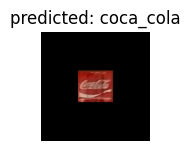

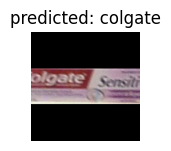

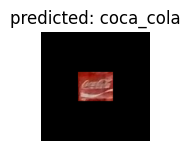

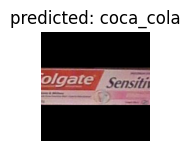

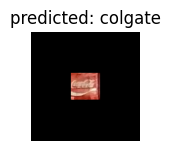

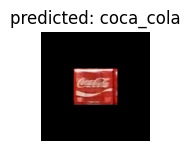

In [9]:
#taking some images from the validation set and showing the predicted label of our resnet50
visualize_model(model_ft)